2025-08-05 13:50:54.040969: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 13:50:54.078033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 13:50:54.078068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 13:50:54.079421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 13:50:54.085938: I tensorflow/core/platform/cpu_feature_guar

Skipping frame 28_05_01.png as ground truth has no positive pixels.
Sequence 1, Frame 2 (28_05_02.png):
  F1: 0.0066, IoU: 0.0033, Precision: 0.0043, Recall: 0.0136


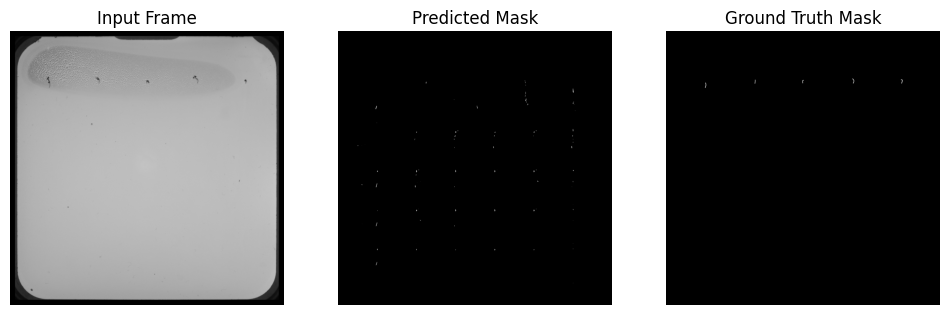

Sequence 1, Frame 3 (28_05_03.png):
  F1: 0.1659, IoU: 0.0904, Precision: 0.1269, Recall: 0.2396


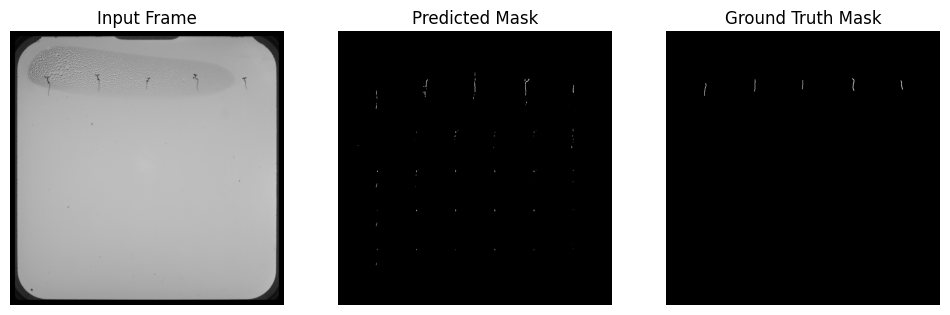

Sequence 1, Frame 4 (28_05_04.png):
  F1: 0.3066, IoU: 0.1810, Precision: 0.2957, Recall: 0.3182


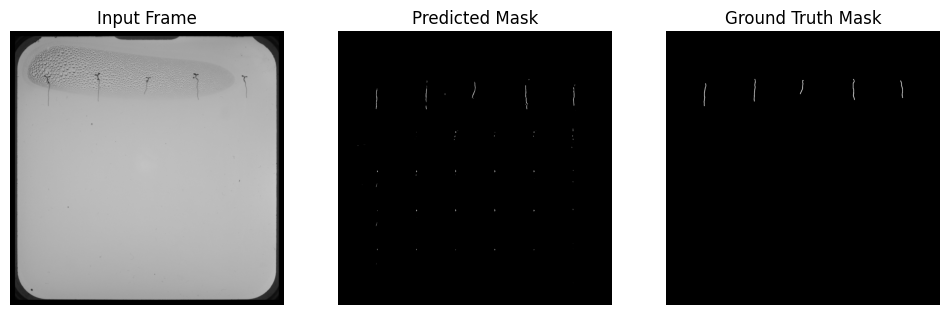

Sequence 1, Frame 5 (28_05_05.png):
  F1: 0.4074, IoU: 0.2558, Precision: 0.4714, Recall: 0.3587


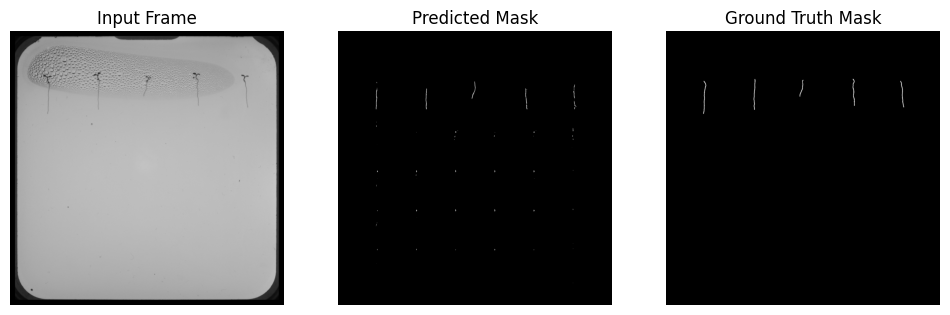

Sequence 1, Frame 6 (28_05_06.png):
  F1: 0.4112, IoU: 0.2588, Precision: 0.5146, Recall: 0.3424


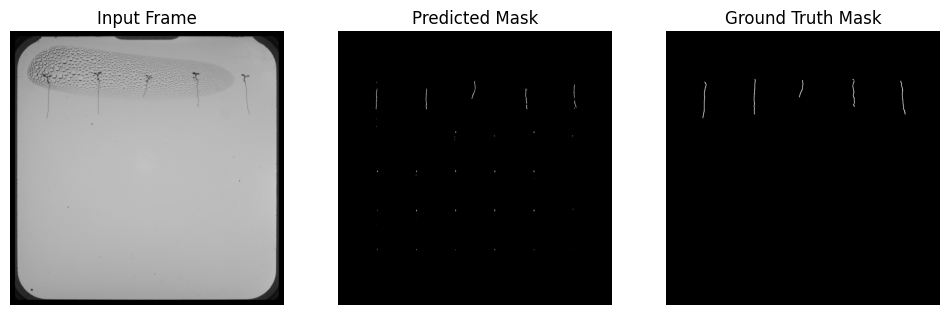

Sequence 1, Frame 7 (28_05_07.png):
  F1: 0.4277, IoU: 0.2720, Precision: 0.5342, Recall: 0.3567


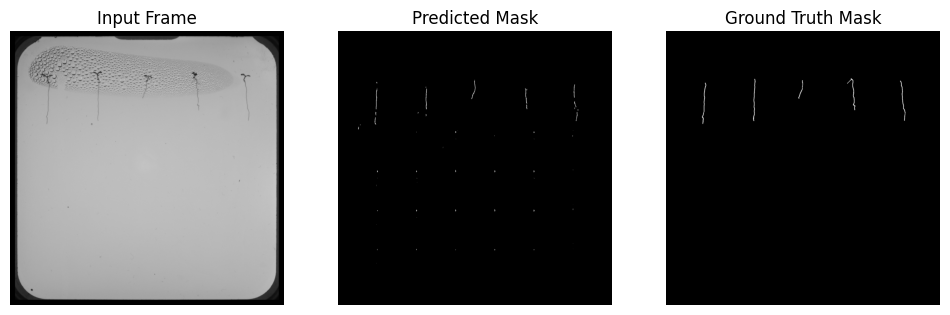

Sequence 1, Frame 8 (28_05_08.png):
  F1: 0.4239, IoU: 0.2690, Precision: 0.5410, Recall: 0.3485


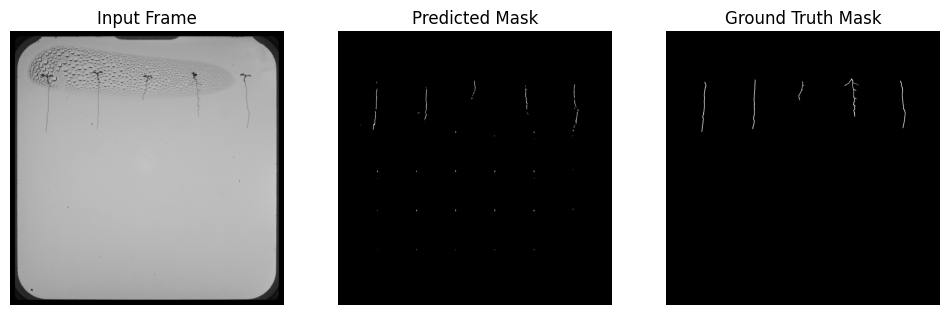

Sequence 1, Frame 9 (28_05_09.png):
  F1: 0.4261, IoU: 0.2708, Precision: 0.5504, Recall: 0.3476


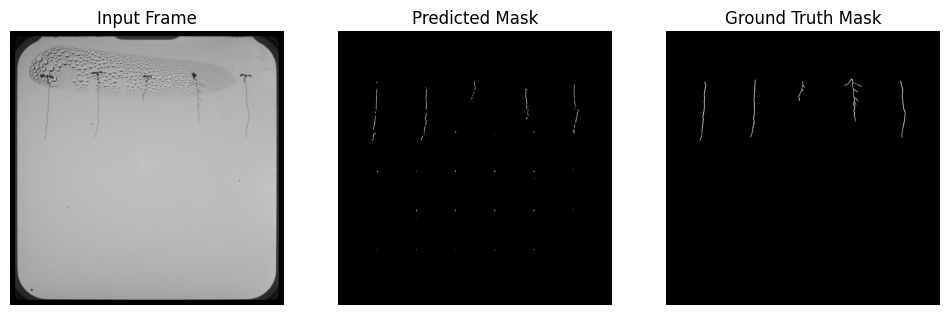

Sequence 1, Frame 10 (28_05_10.png):
  F1: 0.4077, IoU: 0.2560, Precision: 0.5799, Recall: 0.3143


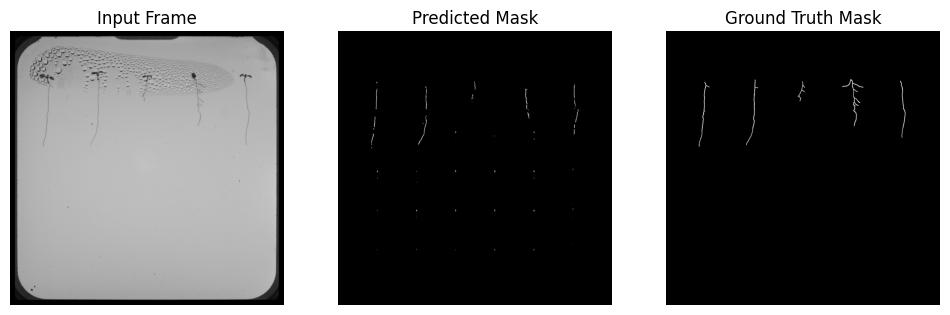

Sequence 1, Frame 11 (28_05_11.png):
  F1: 0.3797, IoU: 0.2343, Precision: 0.5789, Recall: 0.2825


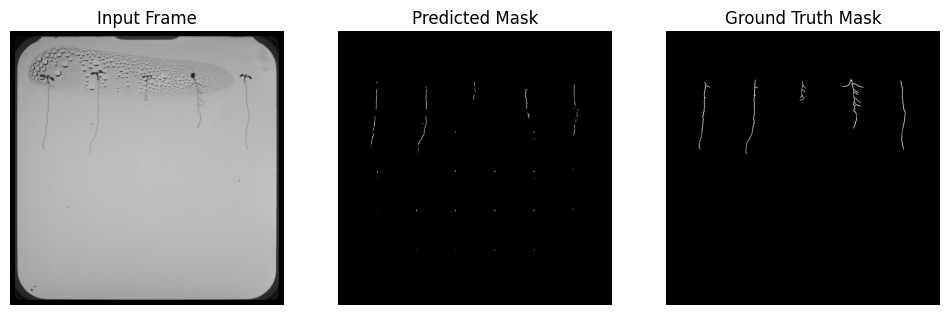

Sequence 1, Frame 12 (28_05_12.png):
  F1: 0.3448, IoU: 0.2083, Precision: 0.5304, Recall: 0.2554


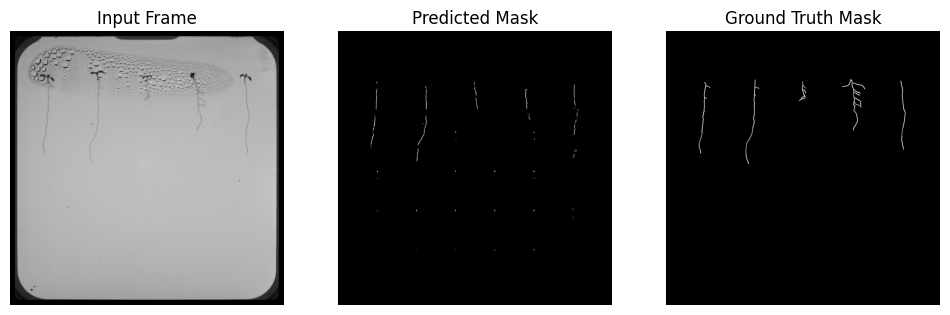

Sequence 1, Frame 13 (28_05_13.png):
  F1: 0.3373, IoU: 0.2029, Precision: 0.5606, Recall: 0.2412


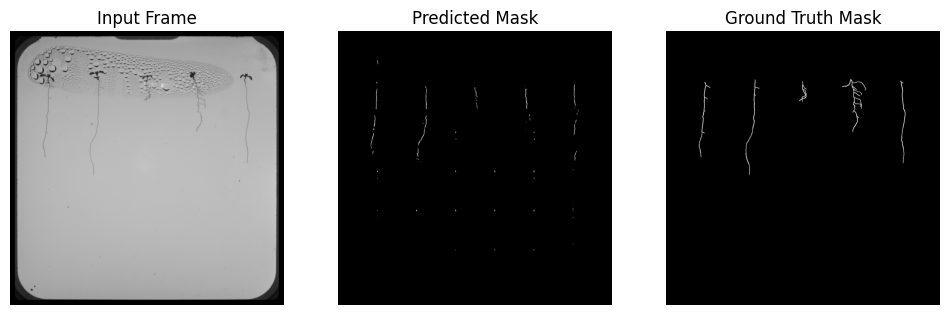

Sequence 1, Frame 14 (28_05_14.png):
  F1: 0.2992, IoU: 0.1759, Precision: 0.5534, Recall: 0.2050


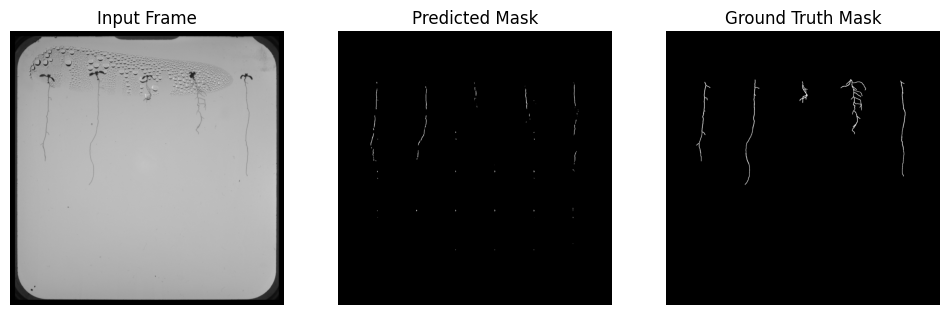

Sequence 1, Frame 15 (28_05_15.png):
  F1: 0.2139, IoU: 0.1197, Precision: 0.5094, Recall: 0.1354


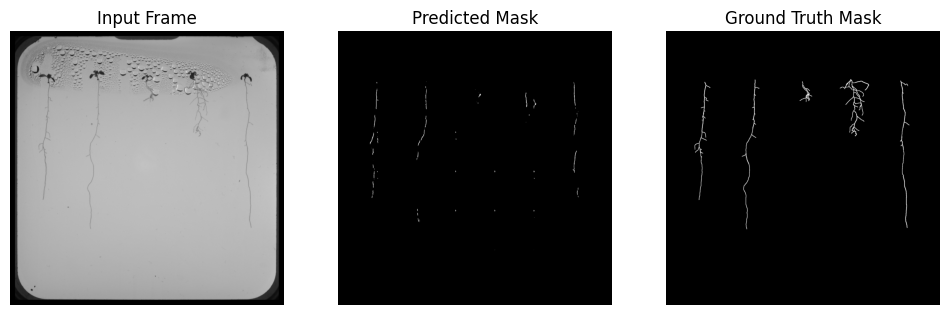

=== Average Metrics over all frames ===
Avg F1 Score: 0.3256
Avg mIoU: 0.1999
Avg Precision: 0.4537
Avg Recall: 0.2685


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
from sklearn.metrics import jaccard_score, precision_score, recall_score
from sklearn.metrics import f1_score as f1_metric

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def pipeline(image_dir, time_steps=15, kernel_size=5, patch_size=256):
    # Load the trained LSTM-UNet model
    model_path = "lstm_vit_model.h5"
    model = load_model(model_path, custom_objects={"f1": f1})

    # Load image file names
    files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_dir = image_dir

    # Metrics storage
    all_f1, all_iou, all_precision, all_recall = [], [], [], []

    num_sequences = len(files) // time_steps
    for seq_idx in range(num_sequences):
        seq_files = files[seq_idx * time_steps:(seq_idx + 1) * time_steps]
        frames_padded = []
        stats, centroids = None, None

        # Preprocess each frame in the sequence
        for file in seq_files:
            img_path = os.path.join(image_dir, file)
            image = cv2.imread(img_path, 0)  # Grayscale
            image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
            image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
            image_np = image_color / 255.0
            image_padded = padder(image_np, patch_size=patch_size)
            frames_padded.append(image_padded)

        frames_padded = np.array(frames_padded)  # (time_steps, H, W, 3)
        H, W, _ = frames_padded[0].shape

        # Patchify all frames
        patches_seq = []
        for t in range(time_steps):
            patches = patchify(frames_padded[t], (patch_size, patch_size, 3), step=patch_size)
            patches_seq.append(patches)

        patches_seq = np.stack(patches_seq, axis=2)
        num_x, num_y = patches_seq.shape[:2]

        # Reshape to (num_patches, time_steps, patch_size, patch_size, 3)
        patches_seq = patches_seq.reshape(-1, time_steps, patch_size, patch_size, 3)

        # Predict masks for all time steps
        predicted_patches = model.predict(patches_seq, verbose=0)

        # Reshape back to (num_x, num_y, time_steps, patch_size, patch_size)
        predicted_patches = predicted_patches.reshape(num_x, num_y, time_steps, patch_size, patch_size)

        # Process each frame
        for t in range(time_steps):
            predicted_mask = unpatchify(predicted_patches[:, :, t, :, :], (H, W))
            prediction_bool = (predicted_mask > 0.5).astype(np.uint8)

            # Load corresponding ground truth mask
            mask_filename = seq_files[t].replace('.png', '.tif')
            mask_path = os.path.join(mask_dir, mask_filename)
            if not os.path.exists(mask_path):
                print(f"Mask for {seq_files[t]} not found, skipping frame...")
                continue

            mask = cv2.imread(mask_path, 0)
            mask = crop_to_coordinates(mask, stats, centroids)
            mask = padder(mask, patch_size=patch_size)
            mask_bool = (mask > 0.5).astype(np.uint8)

            if np.sum(mask_bool) == 0:
                print(f"Skipping frame {seq_files[t]} as ground truth has no positive pixels.")
                continue

            # Compute metrics
            pred_flat = prediction_bool.flatten()
            mask_flat = mask_bool.flatten()
            f1_val = f1_metric(mask_flat, pred_flat)
            iou_val = jaccard_score(mask_flat, pred_flat)
            precision_val = precision_score(mask_flat, pred_flat)
            recall_val = recall_score(mask_flat, pred_flat)

            all_f1.append(f1_val)
            all_iou.append(iou_val)
            all_precision.append(precision_val)
            all_recall.append(recall_val)

            print(f"Sequence {seq_idx+1}, Frame {t+1} ({seq_files[t]}):")
            print(f"  F1: {f1_val:.4f}, IoU: {iou_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}")

            # Plot input frame, predicted mask, ground truth mask
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input Frame")
            plt.imshow(frames_padded[t])
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("Predicted Mask")
            plt.imshow(prediction_bool, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title("Ground Truth Mask")
            plt.imshow(mask_bool, cmap='gray')
            plt.axis('off')

            plt.show()

    # Average metrics over all frames in all sequences
    if all_f1:
        print("=== Average Metrics over all frames ===")
        print(f"Avg F1 Score: {np.mean(all_f1):.4f}")
        print(f"Avg mIoU: {np.mean(all_iou):.4f}")
        print(f"Avg Precision: {np.mean(all_precision):.4f}")
        print(f"Avg Recall: {np.mean(all_recall):.4f}")
    else:
        print("No valid frames processed.")


# Run the pipeline
pipeline('../LSTM-Unet/data_v3_processed/test')